In [1]:
import findspark
import os
spark_location='/Users/yiminghuang/Documents/Dev/Apache-Spark/spark-2.4.5-bin-hadoop2.7/' # Set your own
java8_location= '/Library/Java/JavaVirtualMachines/jdk1.8.0_251.jdk/Contents/Home' # Set your own


In [2]:
from sqlalchemy import create_engine
class SteamObject(object):
    
    def config_database_MySQLConnect(self, username,password,host,database):
        engine = create_engine('mysql+pymysql://{}:{}@{}/{}?charset=utf8mb4'.format(username, password, host, database))
        return engine
        
    def MySQL_query(self, query):
        df = pd.read_sql_query(query,engine)
        return df

In [3]:
# enter your username,password, host and database in mySQL
Steam = SteamObject()
# config database connection
username = ''
password = ''
host = ''
database = ''
engine = Steam.config_database_MySQLConnect(username,password,host,database)


In [4]:
os.environ['JAVA_HOME'] = java8_location

findspark.init(spark_home=spark_location) 

In [5]:
from pyspark.sql import SparkSession

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from sqlalchemy import create_engine, types
import pandas as pd

In [6]:
if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("ALS model")\
        .getOrCreate()

In [10]:
query2 = '''SELECT user_id,app_id, playtime_forever FROM game_steam_user_inventory where playtime_forever <> 0'''
df_game_time = Steam.MySQL_query(query2)
df_game_time.head()

,user_id,app_id,playtime_forever
0,76561198158086086,4000,370
1,76561198158086086,110800,9
2,76561198158086086,250320,507
3,76561198158086086,296470,78
4,76561198158086086,301520,20


In [30]:
class cdfTransformer(object):
    
    transformerSeries = {}
    
    def fitTransform(self,data):
        grouped1 = data.groupby(["app_id","playtime_forever"]).count()
        grouped2 = grouped1.groupby(level=[0]).cumsum()
        grouped3 = grouped2.groupby(level = [0]).max()
        withcdf = grouped2/grouped3
        self.transformerSeries = pd.Series(withcdf['user_id'],index=withcdf.index)
        withcdf_df = withcdf.reset_index(level=[0,1])
        withcdf_df.rename(columns={"user_id":"playtime_cdf"}, inplace=True)
        df = pd.merge(withcdf_df,df_game_time, on=['app_id','playtime_forever'],how='inner')
        df.drop('playtime_forever',axis =1, inplace =True)
        df = df[['user_id','app_id','playtime_cdf']]
        df = df.rename(columns={'playtime_cdf':'rating'})
        return df

In [31]:
df_ratings = cdfTransformer().fitTransform(df_game_time)
df_ratings

,user_id,app_id,rating
0,76561198069986134,10,0.054187
1,76561198062431903,10,0.054187
2,76561198218988347,10,0.054187
3,76561198060984502,10,0.054187
4,76561198056211205,10,0.054187
...,...,...,...
266128,76561198120451477,502550,0.500000
266129,76561198190696911,502550,0.625000
266130,76561198145511975,502550,0.750000
266131,76561198192272162,502550,0.875000


In [32]:
# to adapt the ALS model, transform userId and appId into the number starting from 0...to n
def constructCodes(df) :
    """
    Maps 'steamid' to categorical code 'sid'
    Maps 'appid' to categorical code 'aid'
    Returns :
        1. Dataframe with columns 'sid', 'aid', 'playtime_forever'
        2. Dictionary mapping 'steamid' to 'sid'
        3. Dictionary mapping 'sid' to 'steamid'
        4. Dictionary mapping 'appid' to 'aid'
        5. Dictionary mapping 'aid' to 'appid'
    """
    coded_df = df.copy(deep = True)
    coded_df["user_id"] = coded_df["user_id"].astype("category")
    coded_df["app_id"] = coded_df["app_id"].astype("category")
    coded_df["uid"] = coded_df["user_id"].cat.codes
    coded_df["aid"] = coded_df["app_id"].cat.codes
    
    uid_to_userid = dict(enumerate(coded_df["user_id"].cat.categories))
    aid_to_appid = dict(enumerate(coded_df["app_id"].cat.categories))
    userid_to_uid = {v : k for k, v in uid_to_userid.items()}
    appid_to_aid = {v : k for k, v in aid_to_appid.items()}
    
    coded_df.drop(["user_id", "app_id"], axis = 1, inplace = True)
    
    return(coded_df, userid_to_uid, uid_to_userid, appid_to_aid, aid_to_appid)

In [33]:
coded_df, userid_to_uid, uid_to_userid, appid_to_aid, aid_to_appid = constructCodes(df_ratings)

In [34]:
coded_df = coded_df[['uid','aid','rating']]

In [35]:
coded_df.to_csv('rating.csv',index=False)

In [36]:
lines = spark.read.option("header", "true").csv("rating.csv").rdd
ratingsRDD = lines.map(lambda p: Row(userId=int(p[0]), appId=int(p[1]),
                                         rating=float(p[2])))
ratings = spark.createDataFrame(ratingsRDD)

In [37]:
(training, test) = ratings.randomSplit([0.7, 0.3])

In [38]:
lines = spark.read.option("header", "true").csv("rating.csv").rdd
ratingsRDD = lines.map(lambda p: Row(userId=int(p[0]), appId=int(p[1]),
                                         rating=float(p[2])))
ratings = spark.createDataFrame(ratingsRDD)
(training, test) = ratings.randomSplit([0.8, 0.2])

## Hyperparameter Tuning

In [39]:
min_error = float('inf')
best_rank = -1
best_regularization = 0

num_iterations = 15
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_Params = [0.001, 0.01, 0.05, 0.1]
for rank in ranks:
    for reg in reg_Params: 
        # get ALS model
        als = ALS(maxIter=num_iterations, regParam=reg, rank=rank, userCol="userId", itemCol="appId", ratingCol="rating",coldStartStrategy="drop")
        model = als.fit(training)
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        print(' {} latent factors, regularization = {}: '
                  'validation RMSE is {}'.format( rank, reg , rmse))
        if rmse < min_error:   
            min_error = rmse
            best_rank = rank
            best_regularization = reg
            best_maxIter = num_iterations
            
print('\nThe best model has {} latent factors and '
          'regularization = {} when number of iterations is {}'.format(best_rank, best_regularization,best_maxIter))


 8 latent factors, regularization = 0.001: validation RMSE is 0.35521110894362523


KeyboardInterrupt: 

In [26]:
import matplotlib.pyplot as plt

def plot_learning_curve(arr_iters,train, test):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        als = ALS(maxIter= num_iters, regParam=0.05, rank=20, userCol="userId", itemCol="appId", ratingCol="rating",coldStartStrategy="drop")
        model = als.fit(train)
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        errors.append(rmse)
    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)

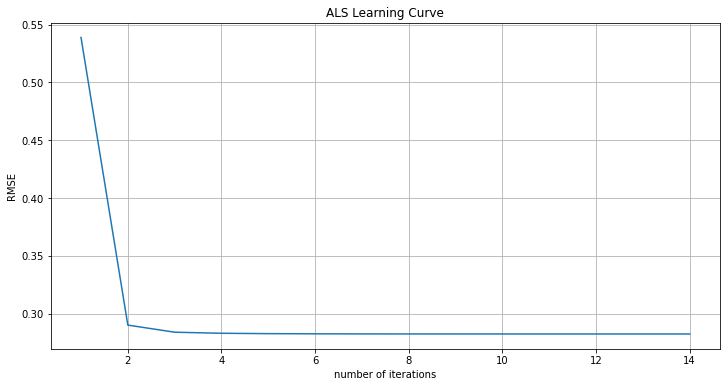

In [27]:
iter_array = list(range(1, 15))
# create learning curve plot
plot_learning_curve(iter_array, training, test)

In [ ]:
## Modeling 

In [81]:
als = ALS(maxIter=15, regParam=0.05, rank=20, userCol="userId", itemCol="appId", ratingCol="rating",coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
rmse = evaluator.evaluate(predictions)


Column<b'appId'>

In [43]:
dic_recomended_als_based = {}
recommended_games = model.recommendForAllUsers(20)
for user, lst_recommended_games in recommended_games.select('userID', 'recommendations.appId').toPandas().set_index('userID')['appId']\
.to_dict().items():
    real_userid = uid_to_userid[user]
    dic_recomended_als_based[real_userid] = {}
    for i, app_id in enumerate(lst_recommended_games):
        real_appid = aid_to_appid[app_id]
        dic_recomended_als_based[real_userid].update({i:real_appid})
df_als_based_result = pd.DataFrame.from_dict(dic_recomended_als_based,'index')
df_als_based_result.index.name = 'user_id'
df_als_based_result.reset_index(inplace=True)
df_als_based_result.to_sql('recommended_games_als_based', engine, if_exists='replace', chunksize = 1000, index = False)



In [51]:
df_als_based_result.shape

(4406, 21)

In [78]:
def hit_rate_metric():
    user_id = df_game_time.groupby('user_id').max().reset_index().user_id.tolist()
    df = df_ratings.loc[df_ratings['rating']>0.8]
    hit = 0
    for user in user_id:
        recommended_lst = df_als_based_result.loc[df_als_based_result['user_id']==user].values.flatten().tolist()[1:11]
        for rec in recommended_lst:
            if rec in df.loc[df['user_id']==user].app_id.tolist():
                hit +=1
    hit_rate = hit/len(user_id)
    return hit_rate
                
        

In [79]:
hit_rate_metric()

0.06309577848388562